# Project: Financial time series forecasting

In [1]:
#!pip install plotly
#!pip install mplfinance

import pandas as pd
from pathlib import Path
import numpy as np
import mplfinance as mpf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, StrMethodFormatter
%matplotlib inline
import plotly as ply
import plotly.graph_objects as go
import sklearn
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler #library for MinMax scaler
from sklearn.metrics import r2_score, mean_squared_error
from functools import reduce
from operator import mul
from pprint import PrettyPrinter

# Grade 1

***Implement a complete process for forecasting the one-day-ahead Close value of the EUR/USD exchange rate, using a historical dataset with one-minute resolution.***

- Download once the [EUR/USD data set](https://people.arcada.fi/~parland/hjd5_8amp_Gt3/EURUSD1m.zip) (52Mb) and convert the index to [DatetimeIndex](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html)
`pd.read_csv("https://people.arcada.fi/~parland/hjd5_8amp_Gt3/EURUSD1m.zip", compression='zip', [other usefull parameters...])`

- Subsample data to one-day time steps, ensuring you also include data from weekends.

- Create a 'Label' column for your forecast by shifting the Close value one step forward. You will be predicting one day ahead.

- Split the data into an 80/20 ratio (train/test). Be cautious: you are splitting a time series.


- [Normalize or standardize](https://scikit-learn.org/stable/modules/preprocessing.html) wisely so you don't allow information leakage to the test subset. Note, that utility class [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) performs scaling **individual samples to have unit norm**, so it is not useful for certain tasks. Write your own function or check [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) or [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

- Please check in which order you perform split and scale. 

- Calculate the technical analysis feature [Larry William’s %R](https://www.investopedia.com/terms/w/williamsr.asp) from the paper [Predicting the Direction of Stock Market Index Movement Using an Optimized Artificial Neural Network Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4873195)


- Drop other data than the Close and the features for training and inference. You don't want to feed time-column into the model, it's usually not a feature to base your prediction on. 

- Fit a [linear model](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) to the training data

- Forecast one day ahead based on the test data

- Calculate the [R² error](https://en.wikipedia.org/wiki/Coefficient_of_determination) on both the training data set and the test. Please format numbers to four [significant digits](https://en.wikipedia.org/wiki/Significant_figures). 

- Compare the R² errors for test and train and explain the outcome. 


### Answer to Grade 1 ###

In [2]:
#download the dataset from the website 
data = pd.read_csv("https://people.arcada.fi/~parland/hjd5_8amp_Gt3/EURUSD1m.zip", compression='zip')
data['Date'] = data['Date'].astype(str)
# Combine the 'Date' and 'Timestamp' columns into a single DateTime column
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Timestamp'], format='%Y%m%d %H:%M:%S')
# Set the 'DateTime' column as the index
data = data.set_index('DateTime')
# Drop the original 'Date' and 'Timestamp' columns (optional)
data = data.drop(columns=['Date', 'Timestamp'])
# Resample the data to daily frequency ('D'), including weekends

# Forward-fill missing data from weekdays to weekends
daily_data = data.resample('D').ffill()
# Create the 'Label' column by shifting the 'Close' column one step forward
daily_data['Label'] = daily_data['Close'].shift(-1)


# Create the '7 days ahead' column by shifting the 'Close' column 7 step forward (We need it in the last section of this project)
daily_data['7 days ahead'] = daily_data['Close'].shift(-7)


################################################# Calculation of William's R##########################################################################

#function to calculate William's R
def williams_r(df, period):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    williams_r_value = ((highest_high - df['Close']) / (highest_high - lowest_low)) * -100
    df['Williams_%R'] = williams_r_value
    return df


# Calculate William's R and  merge with the original data
data_with_WR = williams_r(daily_data, period=3)


data_with_WR_cleaned = data_with_WR[['Open', 'High', 'Low', 'Volume','Williams_%R', 'Label']].dropna() ##Removing rows with NaN


##################################################################Spiltting the data set ############################################################
# Determine the split index for an 80/20 train/test split
split_index = int(len(data_with_WR_cleaned) * 0.8)



# Split the data into training and test sets
train_data_WR = data_with_WR_cleaned[:split_index]  # First 80%
test_data_WR = data_with_WR_cleaned[split_index:]   # Remaining 20%

####################################################################Normalizing the dataset############################################################

#Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler only on the training data
scaler.fit(train_data_WR)

# Transform both the training and test data using the same scaler
train_data_scaled_WR = scaler.transform(train_data_WR)
test_data_scaled_WR = scaler.transform(test_data_WR)

# Convert the scaled data back into a DataFrame for easy inspection
train_data_scaled_df_WR = pd.DataFrame(train_data_scaled_WR, index=train_data_WR.index, columns=train_data_WR.columns)
test_data_scaled_df_WR = pd.DataFrame(test_data_scaled_WR, index=test_data_WR.index, columns=test_data_WR.columns)

#Create dataframe for feature and target
feature_WR = train_data_scaled_df_WR[['Open', 'High', 'Low', 'Volume','Williams_%R']]
target_WR = train_data_scaled_df_WR['Label']

#####################################################################Fitting the Linear Regression Model#############################################

# Fit the linear regression model to the training data
model = LinearRegression()
model.fit(feature_WR, target_WR)


# Evaluate the model by predicting the train set
y_train_WR = train_data_scaled_df_WR.Label
ytrain_pred_WR = model.predict(train_data_scaled_df_WR[['Open', 'High', 'Low',  'Volume','Williams_%R']])
r2_train_WR = r2_score(y_train_WR, ytrain_pred_WR)
print(f"R Squared Error for train dataset with WR as a feature: {r2_train_WR :.4f}")


# Evaluate the model by predicting the test set
y_test_WR = test_data_scaled_df_WR.Label
ytest_pred_WR = model.predict(test_data_scaled_df_WR[['Open', 'High', 'Low',  'Volume','Williams_%R']])
r2_test_WR = r2_score(y_test_WR, ytest_pred_WR)
print(f"R Squared Error test dataset with WR as a feature: {r2_test_WR :.4f}")


# Check if R squared value for test dataset is less than that of train datset
print(f"r-square on test dataset is less than r-square on train datset: {r2_test_WR <r2_train_WR}")

R Squared Error for train dataset with WR as a feature: 0.9970
R Squared Error test dataset with WR as a feature: 0.9913
r-square on test dataset is less than r-square on train datset: True


### Explanation of the outcome
We observe that the R-squared errors for tran dataset is less than test dataset which is expected. A model always performs better on the training data because it has "seen" that data during training. The test data is new, and the model is evaluated on its ability to generalize what it learned, hence a R squared value is lower on the test dataset.

<a id='g2'></a>
# Grade 2
## Illustrate data using [plotly](https://plotly.com/python/getting-started/) (or other) library

- Calculate additional feature [Stochastic slow %D](https://www.investopedia.com/ask/answers/05/062405.asp)
- Create a figure based on OHLC candles **covering the test period** (the 20% of data)
- Add a line to the chart that illustrates the *label* (actual data) and the *forecast* (so candels and lines are in the same figure. The lines should have different colors and include names of the series.
- Add **subplot(s)** with the LW%R and Stochastic slow %D features, below the figure with OHLC, label and forecast, so we can see all time-aligned. Don't forget to sclae back the predicted values to the original range.
- What patterns can you observe from the line figure?

## Answer to Grade 2

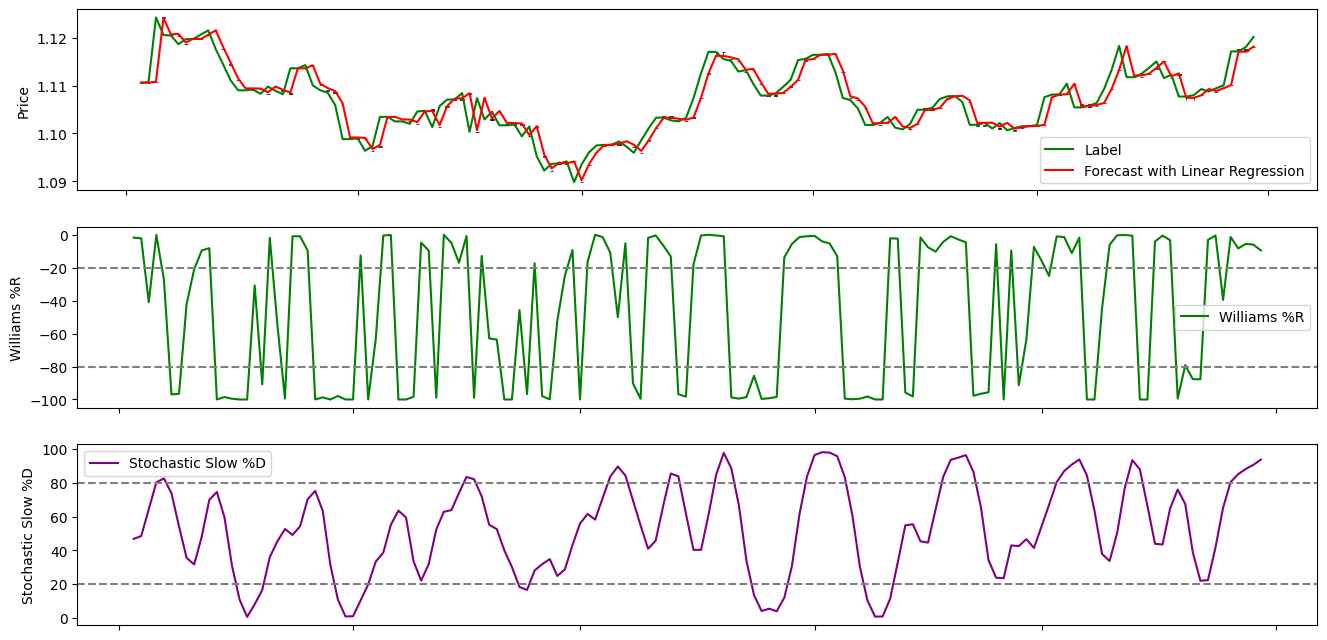

In [3]:
###Calculation of Stochastic slow %D
def calculate_stochastic(data, n):
    # Calculate Stochastic %K
    data['High_n'] = data['High'].rolling(window=n).max()
    data['Low_n'] = data['Low'].rolling(window=n).min()
    data['%K'] = (data['Close'] - data['Low_n']) / (data['High_n'] - data['Low_n']) * 100
    
    # Calculate Stochastic %D (SMA of %K)
    data['%D'] = data['%K'].rolling(window=n).mean()
    
    # Calculate Stochastic Slow %D (SMA of %D)
    data['Slow %D'] = data['%D'].rolling(window=n).mean()
    
    # Drop intermediate columns 'High_n' and 'Low_n'
    data.drop(columns=['High_n', 'Low_n'], inplace=True)
    
    return data

# Calculate K, D, slow D and merge with the original data
data_with_WR_SK = calculate_stochastic(daily_data, n=3)




data_for_plotting = (data_with_WR_SK.loc[test_data_scaled_df_WR.index]).iloc[-150:]

############################################################## inverse transform of the scaled data before plotting ##################################################################################################

# Prepare a temporary array with the same shape as the scaled data
temp1 = np.zeros_like(test_data_scaled_df_WR)
# Populate only the 'Close' column (4th column in this case) with the scaled values
temp1[:, test_data_scaled_df_WR.columns.get_loc('Label')] = ytest_pred_WR
# Use inverse_transform on the temporary array
ytest_pred_original = scaler.inverse_transform(temp1)[:, test_data_scaled_df_WR.columns.get_loc('Label')]  ## y test predicted value without transformation

# Prepare a temporary array with the same shape as the scaled data
temp1a = np.zeros_like(test_data_scaled_df_WR)
# Populate only the 'Close' column (4th column in this case) with the scaled values
temp1a[:, test_data_scaled_df_WR.columns.get_loc('Label')] = y_test_WR
# Use inverse_transform on the temporary array
ytest_original = scaler.inverse_transform(temp1a)[:, test_data_scaled_df_WR.columns.get_loc('Label')] ## y test original value without transformation

# Prepare a temporary array with the same shape as the scaled data
temp2 = np.zeros_like(train_data_scaled_df_WR)
# Populate only the 'Close' column (4th column in this case) with the scaled values
temp2[:, train_data_scaled_df_WR.columns.get_loc('Label')] = ytrain_pred_WR
# Use inverse_transform on the temporary array
ytrain_pred_original = scaler.inverse_transform(temp2)[:, train_data_scaled_df_WR.columns.get_loc('Label')]  ## y train predicted value without transformation

# Prepare a temporary array with the same shape as the scaled data
temp2a = np.zeros_like(train_data_scaled_df_WR)
# Populate only the 'Close' column (4th column in this case) with the scaled values
temp2a[:, train_data_scaled_df_WR.columns.get_loc('Label')] = y_train_WR
# Use inverse_transform on the temporary array
ytrain_original = scaler.inverse_transform(temp2a)[:, train_data_scaled_df_WR.columns.get_loc('Label')]  ## y train original value without transformation


#############################################################Plotting the Figure ###################################################


# Visualize OHLC with forecast and actual lines
ohlc_data = data_for_plotting[['Open', 'High', 'Low', 'Close']]

# Create figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 8))

# Plot OHLC candlestick chart for the test period
mpf.plot(ohlc_data, type='candle', ax=ax1, show_nontrading=True)
#ax2.axhline(0, color='gray', linestyle='--')  
#ax2.axhline(-100, color='gray', linestyle='--')  
ax1.plot(data_for_plotting.index, ytest_original[-150:], label='Label', color='green')
ax1.plot(data_for_plotting.index, ytest_pred_original[-150:], label='Forecast with Linear Regression', color='red')
#ax1.plot(data_for_plotting.index, ytest_pred_original_Elasticnet[-150:], label='Forecast with ElasticNet', color='red')

ax1.legend()



# Plot Williams %R
ax2.plot(data_for_plotting.index, data_for_plotting['Williams_%R'], label='Williams %R', color='green')
ax2.axhline(-20, color='gray', linestyle='--')  
ax2.axhline(-80, color='gray', linestyle='--')  
#ax2.set_title('Williams %R')
ax2.set_ylabel('Williams %R')
ax2.legend()


# Plot Slow Stochastic %D
ax3.plot(data_for_plotting.index, data_for_plotting['Slow %D'], label='Stochastic Slow %D', color='purple')
ax3.axhline(80, color='gray', linestyle='--')  
ax3.axhline(20, color='gray', linestyle='--')  
#ax3.set_title('Stochastic Slow %D')
ax3.set_ylabel('Stochastic Slow %D')
ax3.legend()



# Hide the x-tick labels for the first two subplots (ax1,ax2 and ax3)
ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)
ax3.tick_params(labelbottom=False)




Although I plotted the OHLC figure in the first subplot it is not clearly visible. 
Regarding the line figures, the actual values(label column) is consistently lagging the forecast line.

<a id='g3'></a>
### Grade 3 

- Calculate additional feature [RSI (relative strength index)](https://www.investopedia.com/terms/r/rsi.asp)
- Add the feature as a subplot to the figure in the previos step
- Set up an [ElasticNet](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net) (**not** an [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)) model
- Fit/train the ElasticNet to the training data
- Forecast and calculate the R² error on both the training data set and the test
- Add your new *forecast* line to the previos figure, so the predictions from both models are placed over each other and can be compared
- Compare the errors and explain the outcome

R² score with ElasticNET on training data: 0.0000
R² score with ElasticNET on test data: -5.9223


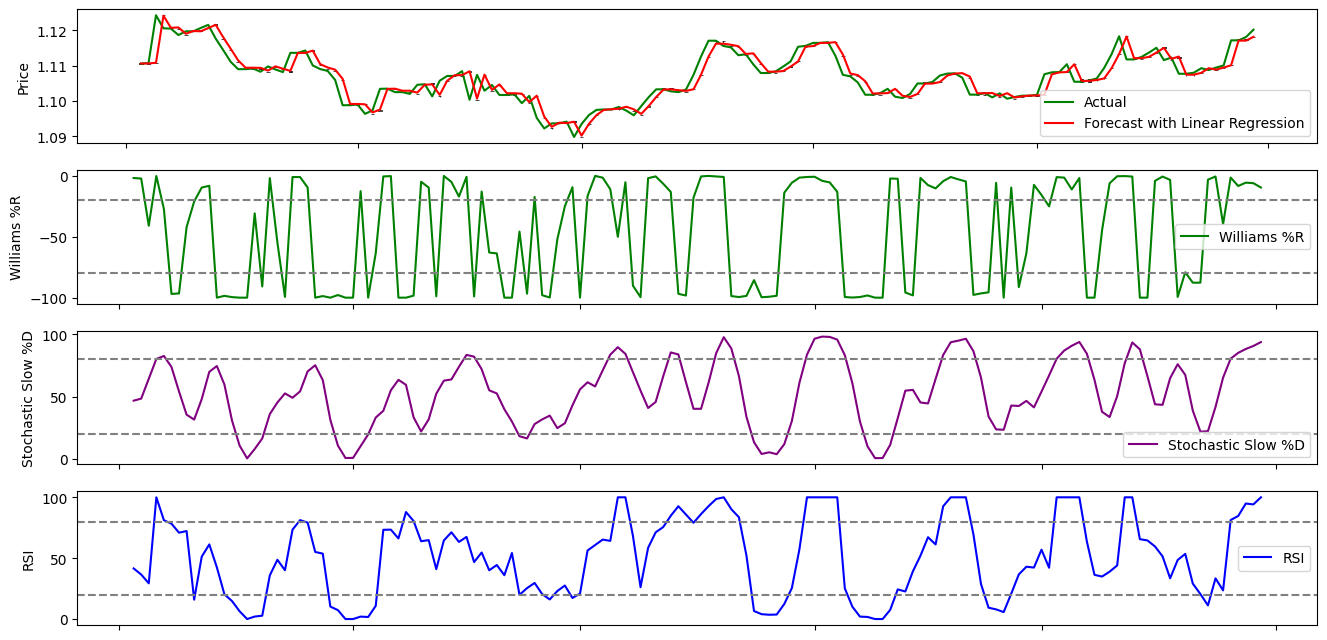

In [4]:
### Calculation of RSI
def calculate_rsi(data, window):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data


# Calculate RSI and merge with the original data and dropping rows with NaN
data_with_WR_SK_RSI = calculate_rsi(daily_data, window=5)
data_with_WR_SK_RSI_cleaned = data_with_WR_SK_RSI[['Open', 'High', 'Low', 'Volume','Label','Williams_%R', 'Slow %D', 'RSI']].dropna()



# Determine the split index for an 80/20 train/test split
split_index = int(len(data_with_WR_SK_RSI_cleaned) * 0.8)
# Split the data into training and test sets
train_data_WR_SK_RSI = data_with_WR_SK_RSI_cleaned[:split_index]  # First 80%
test_data_WR_SK_RSI = data_with_WR_SK_RSI_cleaned[split_index:]   # Remaining 20%


#########################################   Normalize the data #######################################

# Identify the columns to normalize
columns_to_normalize = ['Open', 'High', 'Low', 'Volume','Williams_%R', 'Slow %D', 'RSI','Label']

scaler = MinMaxScaler(feature_range=(0, 1))

train_data_WR_SK_RSI = train_data_WR_SK_RSI.copy()
test_data_WR_SK_RSI = test_data_WR_SK_RSI.copy()


# Fit the scaler on the training data and transform it
train_data_WR_SK_RSI.loc[:, columns_to_normalize] = scaler.fit_transform(train_data_WR_SK_RSI.loc[:, columns_to_normalize])

# Use the same scaler to transform the test data (without fitting again to avoid data leakage)
test_data_WR_SK_RSI.loc[:, columns_to_normalize] = scaler.transform(test_data_WR_SK_RSI.loc[:, columns_to_normalize])


feature_WR_SK_RSI = train_data_WR_SK_RSI[['Open', 'High', 'Low', 'Volume','Williams_%R', 'Slow %D', 'RSI']]
target_WR_SK_RSI = train_data_WR_SK_RSI['Label']


##########################################################Fitting the ElasticNet model ######################################
# Fit the Elasticnet model to the training data
elastic_net = ElasticNet()  
elastic_net.fit(feature_WR_SK_RSI, target_WR_SK_RSI)


# Evaluate the model
y_train_pred_WR_SK_RSI = elastic_net.predict(feature_WR_SK_RSI)
y_test_pred_WR_SK_RSI = elastic_net.predict(test_data_WR_SK_RSI[['Open', 'High', 'Low', 'Volume','Williams_%R', 'Slow %D', 'RSI']])

ytest = test_data_WR_SK_RSI['Label']

# Calculate R² scores
r2_train_WR_SK_RSI = r2_score(target_WR_SK_RSI, y_train_pred_WR_SK_RSI)
r2_test_WR_SK_RSI = r2_score(ytest, y_test_pred_WR_SK_RSI)

# Output results
print(f"R² score with ElasticNET on training data: {r2_train_WR_SK_RSI:.4f}")
print(f"R² score with ElasticNET on test data: {r2_test_WR_SK_RSI:.4f}")



## inverse transform of predicted value in the similar manner we did before
temp1c = np.zeros_like(test_data_WR_SK_RSI)  
temp1c[:, test_data_WR_SK_RSI.columns.get_loc('Label')] = y_test_pred_WR_SK_RSI 

ytest_pred_original_Elasticnet = scaler.inverse_transform(temp1c)[:, test_data_WR_SK_RSI.columns.get_loc('Label')]  # Get the original 'Label' values



##########################################################Plotting the data #########################################################

data_for_plotting = (data_with_WR_SK_RSI.loc[test_data_scaled_df_WR.index]).iloc[-150:]

# Visualize OHLC with forecast and actual lines
ohlc_data = data_for_plotting[['Open', 'High', 'Low', 'Close']]

# Create figure and subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 8))

# Plot OHLC candlestick chart for the test period
mpf.plot(ohlc_data, type='candle', ax=ax1, show_nontrading=True)
#ax2.axhline(0, color='gray', linestyle='--')  
#ax2.axhline(-100, color='gray', linestyle='--')  
ax1.plot(data_for_plotting.index, ytest_original[-150:], label='Actual', color='green')
ax1.plot(data_for_plotting.index, ytest_pred_original[-150:], label='Forecast with Linear Regression', color='red')
#ax1.plot(data_for_plotting.index, ytest_pred_original_Elasticnet[-150:], label='Forecast with ElasticNet', color='red')

ax1.legend()


# Plot Williams %R
ax2.plot(data_for_plotting.index, data_for_plotting['Williams_%R'], label='Williams %R', color='green')
ax2.axhline(-20, color='gray', linestyle='--')  
ax2.axhline(-80, color='gray', linestyle='--')  
#ax2.set_title('Williams %R')
ax2.set_ylabel('Williams %R')
ax2.legend()


# Plot Slow Stochastic %D
ax3.plot(data_for_plotting.index, data_for_plotting['Slow %D'], label='Stochastic Slow %D', color='purple')
ax3.axhline(80, color='gray', linestyle='--')  
ax3.axhline(20, color='gray', linestyle='--')  
#ax3.set_title('Stochastic Slow %D')
ax3.set_ylabel('Stochastic Slow %D')
ax3.legend()



# Hide the x-tick labels for the first two subplots (ax1,ax2 and ax3)
ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)
ax3.tick_params(labelbottom=False)
ax4.tick_params(labelbottom=False)


# Plot Slow RSI
ax4.plot(data_for_plotting.index, data_for_plotting['RSI'], label='RSI', color='blue')
ax4.axhline(80, color='gray', linestyle='--')  
ax4.axhline(20, color='gray', linestyle='--')  
#ax4.set_title('RSI')
ax4.set_ylabel('RSI')
ax4.legend()






### Compare the errors and explain the outcome:

The R-squared value is bad with ElasticNet model. It implies that the model is underfitting or performing poorly, unable to capture the underlying patterns in the data.

<a id='g4'></a>
# Grade 4

- Calculate additional feature [On Balance Volume](https://www.investopedia.com/terms/o/onbalancevolume.asp)
- Create sliding windows for the input data, e.g. the window length of 10, 5, and 2 samples. You will extract data for the window length n (rows), and turn the data from a matrix (2D) form into a vector form of the size $R\times C$ (i.e. number of rows × number of columns in the window) [NumPy Array Reshaping](https://www.w3schools.com/python/numpy_array_reshape.asp). You will probably need to create a function that returns a vector (array, tuple, list, Series).

- Set up a [Polynomial regression](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)
- Fit and run all three different models (on all features) for all three different window lengths
- Summarize and compare their R² error measures. Is anyone better than the [LinearRegression model](https://en.wikipedia.org/wiki/Linear_regression) without window information attached?



### Answer to Grade 4

In [9]:
# Calculate On Balance Volume (OBV)

def calculate_obv(data):
    obv = [0]  # OBV starts at 0 for the first row
    for i in range(1, len(data)):
        if data['Close'].iloc[i] > data['Close'].iloc[i - 1]:
            obv.append(obv[-1] + data['Volume'].iloc[i])
        elif data['Close'].iloc[i] < data['Close'].iloc[i - 1]:
            obv.append(obv[-1] - data['Volume'].iloc[i])
        else:
            obv.append(obv[-1])  # No change if prices are equal
    data['OBV'] = obv
    return data

# Add OBV to the DataFrame
data_with_WR_SK_RSI_OBV = calculate_obv(daily_data)
data_with_WR_SK_RSI_OBV_cleaned = data_with_WR_SK_RSI_OBV.dropna()#Dropping NaN rows from the dataset



################################################3############### Create sliding window length of 2, 5, and 10 ########################################

# Create a sliding window function to generate lagged features
def create_lagged_features(data, window_length):
    df_lagged = data.copy()
    
    # Create lagged columns for each feature
    for i in range(1, window_length):
        lagged_data = data.shift(i)  # Shift the data by 'i' steps
        lagged_data.columns = [f"{col}-{i}" for col in data.columns]  # Rename columns with lag suffix
        df_lagged = pd.concat([df_lagged, lagged_data], axis=1)
    
    return df_lagged

# Apply sliding window of length 2, 5, and 10
window_length_2 = 2
window_length_5 = 5
window_length_10 = 10

lagged_df_2 = create_lagged_features(data_with_WR_SK_RSI_OBV_cleaned, window_length_2)
lagged_df_5 = create_lagged_features(data_with_WR_SK_RSI_OBV_cleaned, window_length_5)
lagged_df_10 = create_lagged_features(data_with_WR_SK_RSI_OBV_cleaned, window_length_10)


########################################## Fit Polynomial regression  ######################################################################################

# Determine the split index for an 80/20 train/test split
split_index = int(len(data_with_WR_SK_RSI_OBV_cleaned) * 0.8)

# Split the data into training and test sets
train_data_with_WR_SK_RSI_OBV = data_with_WR_SK_RSI_OBV_cleaned[:split_index]  # First 80%
test_data_with_WR_SK_RSI_OBV = data_with_WR_SK_RSI_OBV_cleaned[split_index:]   # Remaining 20%


columns_to_normalize = ['Open', 'High', 'Low', 'Volume','Williams_%R', 'Slow %D', 'RSI','OBV']
scaler = MinMaxScaler(feature_range=(0, 1))


train_data_with_WR_SK_RSI_OBV = train_data_with_WR_SK_RSI_OBV.copy()
test_data_with_WR_SK_RSI_OBV = test_data_with_WR_SK_RSI_OBV.copy()


train_data_with_WR_SK_RSI_OBV.loc[:, columns_to_normalize] = scaler.fit_transform(train_data_with_WR_SK_RSI_OBV.loc[:, columns_to_normalize])
# Use the same scaler to transform the test data (without fitting again)
test_data_with_WR_SK_RSI_OBV.loc[:, columns_to_normalize] = scaler.transform(test_data_with_WR_SK_RSI_OBV.loc[:, columns_to_normalize])



feature_with_WR_SK_RSI_OBV = train_data_with_WR_SK_RSI_OBV[['Open', 'High', 'Low', 'Volume','Williams_%R', 'Slow %D', 'RSI','OBV']]
target_feature = train_data_with_WR_SK_RSI_OBV['Label']

# Fit the linear regression model to the training data
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(feature_with_WR_SK_RSI_OBV)

# Fit the Linear Regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly, target_feature)


y_train_pred_WR_SK_RSI_OBV = model.predict(poly.fit_transform(feature_with_WR_SK_RSI_OBV))
y_test_pred_WR_SK_RSI_OBV = model.predict(poly.fit_transform(test_data_with_WR_SK_RSI_OBV[['Open', 'High', 'Low', 'Volume','Williams_%R', 'Slow %D', 'RSI','OBV']]))
ytest = test_data_with_WR_SK_RSI_OBV['Label']


# Calculate R² scores
r2_train_WR_SK_RSI_OBV = r2_score(target_feature, y_train_pred_WR_SK_RSI_OBV)
r2_test_WR_SK_RSI_OBV = r2_score(ytest, y_test_pred_WR_SK_RSI_OBV)


# Output results
print(f"R² score on training data with Polynomial Regression without window information: {r2_train_WR_SK_RSI_OBV:.4f}")
print(f"R² score on test data  with Polynomial Regression without window information: {r2_test_WR_SK_RSI_OBV:.4f}")

############################################# Window size 2 ##################################################################################


lagged_df_2 = lagged_df_2[['Label','Open-1', 'High-1', 'Low-1','Volume-1','Williams_%R-1',  'Slow %D-1','RSI-1', 'OBV-1']] 
lagged_df_2_cleaned = lagged_df_2.dropna()## Dropping NaN


# Split the data into training and test sets
train_lagged_df_2 = lagged_df_2_cleaned[:split_index]  # First 80%
test_lagged_df_2 = lagged_df_2_cleaned[split_index:]   # Remaining 20%


columns_to_normalize = ['Label','Open-1', 'High-1', 'Low-1','Volume-1','Williams_%R-1', 'Slow %D-1','RSI-1', 'OBV-1']
scaler = MinMaxScaler(feature_range=(0, 1))

# Ensure the DataFrame slices are actual copies to avoid the SettingWithCopyWarning
train_lagged_df_2 = train_lagged_df_2.copy()
test_lagged_df_2 = test_lagged_df_2.copy()


train_lagged_df_2[columns_to_normalize] = scaler.fit_transform(train_lagged_df_2[columns_to_normalize])
test_lagged_df_2[columns_to_normalize] = scaler.fit_transform(test_lagged_df_2[columns_to_normalize])

feature_with_lagged_2 = train_lagged_df_2[['Open-1', 'High-1', 'Low-1','Volume-1','Williams_%R-1', 'Slow %D-1','RSI-1', 'OBV-1']]
target_feature_lagged_2 = train_lagged_df_2['Label']

# Fit the linear regression model to the training data
poly = PolynomialFeatures(degree=2)
X_poly_lagged_2 = poly.fit_transform(feature_with_lagged_2)

# Fit the Linear Regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly_lagged_2, target_feature_lagged_2)

y_train_lagged_2_pred_PR = model.predict(poly.fit_transform(feature_with_lagged_2))
y_test_lagged_2_pred_PR = model.predict(poly.fit_transform(test_lagged_df_2[['Open-1', 'High-1', 'Low-1','Volume-1','Williams_%R-1', 'Slow %D-1','RSI-1', 'OBV-1']]))
ytest_lagged_2 = test_lagged_df_2['Label']

# Calculate R² scores
r2_train_lagged_2 = r2_score(target_feature_lagged_2, y_train_lagged_2_pred_PR)
r2_test_lagged_2 = r2_score(ytest_lagged_2, y_test_lagged_2_pred_PR)

# Output results
print(f"R² score on training data with Polynomial Regression with windowlength 2: {r2_train_lagged_2:.4f}")
print(f"R² score on test data with Polynomial Regression with windowlength 2: {r2_test_lagged_2:.4f}")



# Fit the Linear Regression model to the polynomial features
model = LinearRegression()
model.fit(feature_with_lagged_2, target_feature_lagged_2)

y_train_lagged_2_pred_LR = model.predict((feature_with_lagged_2))
y_test_lagged_2_pred_LR = model.predict((test_lagged_df_2[['Open-1', 'High-1', 'Low-1','Volume-1','Williams_%R-1', 'Slow %D-1','RSI-1', 'OBV-1']]))
ytest_lagged_2 = test_lagged_df_2['Label']

# Calculate R² scores
r2_train_lagged_2 = r2_score(target_feature_lagged_2, y_train_lagged_2_pred_LR)
r2_test_lagged_2 = r2_score(ytest_lagged_2, y_test_lagged_2_pred_LR)

# Output results
print(f"R² score on training data with Linear Regression with windowlength 2: {r2_train_lagged_2:.4f}")
print(f"R² score on test data with Linear Regression with windowlength 2: {r2_test_lagged_2:.4f}")


# Fit the Elastic net model
model = ElasticNet()
model.fit(feature_with_lagged_2, target_feature_lagged_2)

y_train_lagged_2_pred_EN = model.predict((feature_with_lagged_2))
y_test_lagged_2_pred_EN = model.predict((test_lagged_df_2[['Open-1', 'High-1', 'Low-1','Volume-1','Williams_%R-1', 'Slow %D-1','RSI-1', 'OBV-1']]))
ytest_lagged_2 = test_lagged_df_2['Label']

# Calculate R² scores
r2_train_lagged_2 = r2_score(target_feature_lagged_2, y_train_lagged_2_pred_EN)
r2_test_lagged_2 = r2_score(ytest_lagged_2, y_test_lagged_2_pred_EN)

# Output results
print(f"R² score on training data with ElasticNet with windowlength 2: {r2_train_lagged_2:.4f}")
print(f"R² score on test data with ElasticNet  with windowlength 2: {r2_test_lagged_2:.4f}")

#################################################################### Windoe size 5 ############################################################


lagged_df_5 = lagged_df_5[['Label','Open-4', 'High-4', 'Low-4','Volume-4','Williams_%R-4', 'Slow %D-4','RSI-4', 'OBV-4']] 
lagged_df_5_cleaned = lagged_df_5.dropna()


# Split the data into training and test sets
train_lagged_df_5 = lagged_df_5_cleaned[:split_index]  # First 80%
test_lagged_df_5 = lagged_df_5_cleaned[split_index:]   # Remaining 20%


columns_to_normalize = ['Label','Open-4', 'High-4', 'Low-4','Volume-4','Williams_%R-4', 'Slow %D-4','RSI-4', 'OBV-4']
scaler = MinMaxScaler(feature_range=(0, 1))

train_lagged_df_5 = train_lagged_df_5.copy()
test_lagged_df_5 = test_lagged_df_5.copy()

# Fit the scaler on the training data and transform it
train_lagged_df_5.loc[:, columns_to_normalize] = scaler.fit_transform(train_lagged_df_5.loc[:, columns_to_normalize])

# Use the same scaler to transform the test data (without fitting again to avoid data leakage)
test_lagged_df_5.loc[:, columns_to_normalize] = scaler.transform(test_lagged_df_5.loc[:, columns_to_normalize])


## Select features and target
feature_with_lagged_5 = train_lagged_df_5[['Open-4', 'High-4', 'Low-4','Volume-4','Williams_%R-4',  'Slow %D-4','RSI-4', 'OBV-4']]
target_feature_lagged_5 = train_lagged_df_5['Label']

# Fit the linear regression model to the training data
poly = PolynomialFeatures(degree=2)
X_poly_lagged_5 = poly.fit_transform(feature_with_lagged_5)

# Fit the Linear Regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly_lagged_5, target_feature_lagged_5)

y_train_lagged_5_pred_PR = model.predict(poly.fit_transform(feature_with_lagged_5))
y_test_lagged_5_pred_PR = model.predict(poly.fit_transform(test_lagged_df_5[['Open-4', 'High-4', 'Low-4','Volume-4','Williams_%R-4',  'Slow %D-4','RSI-4', 'OBV-4']]))
ytest_lagged_5 = test_lagged_df_5['Label']

# Calculate R² scores
r2_train_lagged_5 = r2_score(target_feature_lagged_5, y_train_lagged_5_pred_PR)
r2_test_lagged_5 = r2_score(ytest_lagged_5, y_test_lagged_5_pred_PR)

# Output results
print(f"R² score on training data  with Polynomial Regression with windowlength 5: {r2_train_lagged_5:.4f}")
print(f"R² score on test data  with Polynomial Regression with windowlength 5: {r2_test_lagged_5:.4f}")


# Fit the Linear Regression model
model = LinearRegression()
model.fit(feature_with_lagged_5, target_feature_lagged_5)

y_train_lagged_5_pred_LR = model.predict((feature_with_lagged_5))
y_test_lagged_5_pred_LR = model.predict((test_lagged_df_5[['Open-4', 'High-4', 'Low-4','Volume-4','Williams_%R-4',  'Slow %D-4','RSI-4', 'OBV-4']]))
ytest_lagged_5 = test_lagged_df_5['Label']

# Calculate R² scores
r2_train_lagged_5 = r2_score(target_feature_lagged_5, y_train_lagged_5_pred_LR)
r2_test_lagged_5 = r2_score(ytest_lagged_5, y_test_lagged_5_pred_LR)

# Output results
print(f"R² score on training data with Linear Regression with windowlength 5: {r2_train_lagged_5:.4f}")
print(f"R² score on test data with Linear Regression with windowlength 5: {r2_test_lagged_5:.4f}")

# Fit the ElasticNet model
model = ElasticNet()
model.fit(feature_with_lagged_5, target_feature_lagged_5)


y_train_lagged_5_pred_EN = model.predict((feature_with_lagged_5))
y_test_lagged_5_pred_EN = model.predict((test_lagged_df_5[['Open-4', 'High-4', 'Low-4','Volume-4','Williams_%R-4','Slow %D-4','RSI-4', 'OBV-4']]))
ytest_lagged_5 = test_lagged_df_5['Label']

# Calculate R² scores
r2_train_lagged_5 = r2_score(target_feature_lagged_5, y_train_lagged_5_pred_EN)
r2_test_lagged_5 = r2_score(ytest_lagged_5, y_test_lagged_5_pred_EN)

# Output results
print(f"R² score on training data with ElasticNet with windowlength 5: {r2_train_lagged_5:.4f}")
print(f"R² score on test data with ElasticNet with windowlength 5: {r2_test_lagged_5:.4f}")


################################################ Window size 10 ######################################################################################

lagged_df_10 = lagged_df_10[['Label','Open-9', 'High-9', 'Low-9','Volume-9','Williams_%R-9',  'Slow %D-9','RSI-9', 'OBV-9']] 
lagged_df_10_cleaned = lagged_df_10.dropna()


# Split the data into training and test sets
train_lagged_df_10 = lagged_df_10_cleaned[:split_index]  # First 80%
test_lagged_df_10 = lagged_df_10_cleaned[split_index:]   # Remaining 20%


columns_to_normalize = ['Label','Open-9', 'High-9', 'Low-9','Volume-9','Williams_%R-9',  'Slow %D-9','RSI-9', 'OBV-9']
scaler = MinMaxScaler(feature_range=(0, 1))


# Ensure the DataFrame slices are actual copies to avoid the SettingWithCopyWarning
train_lagged_df_10 = train_lagged_df_10.copy()
test_lagged_df_10 = test_lagged_df_10.copy()

# Fit the scaler on the training data and transform it
train_lagged_df_10.loc[:, columns_to_normalize] = scaler.fit_transform(train_lagged_df_10.loc[:, columns_to_normalize])

# Use the same scaler to transform the test data (without fitting again)
test_lagged_df_10.loc[:, columns_to_normalize] = scaler.transform(test_lagged_df_10.loc[:, columns_to_normalize])


feature_with_lagged_10 = train_lagged_df_10[['Open-9', 'High-9', 'Low-9','Volume-9','Williams_%R-9',  'Slow %D-9','RSI-9', 'OBV-9']]
target_feature_lagged_10 = train_lagged_df_10['Label']

# Fit the linear regression model to the training data
poly = PolynomialFeatures(degree=2)
X_poly_lagged_10 = poly.fit_transform(feature_with_lagged_10)

# Fit the Linear Regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly_lagged_10, target_feature_lagged_10)

y_train_lagged_10_pred_PR = model.predict(poly.fit_transform(feature_with_lagged_10))
y_test_lagged_10_pred_PR = model.predict(poly.fit_transform(test_lagged_df_10[['Open-9', 'High-9', 'Low-9','Volume-9','Williams_%R-9', 'Slow %D-9','RSI-9', 'OBV-9']]))
ytest_lagged_10 = test_lagged_df_10['Label']

# Calculate R² scores
r2_train_lagged_10 = r2_score(target_feature_lagged_10, y_train_lagged_10_pred_PR)
r2_test_lagged_10 = r2_score(ytest_lagged_10, y_test_lagged_10_pred_PR)

# Output results
print(f"R² score on training data with Polynomial Regression with windowlength 10: {r2_train_lagged_10:.4f}")
print(f"R² score on test data with Polynomial Regression with windowlength 10: {r2_test_lagged_10:.4f}")


# Fit the Linear Regression model
model = LinearRegression()
model.fit(feature_with_lagged_10, target_feature_lagged_10)


y_train_lagged_10_pred_LR = model.predict((feature_with_lagged_10))
y_test_lagged_10_pred_LR = model.predict((test_lagged_df_10[['Open-9', 'High-9', 'Low-9','Volume-9','Williams_%R-9', 'Slow %D-9','RSI-9', 'OBV-9']]))
ytest_lagged_10 = test_lagged_df_10['Label']

# Calculate R² scores
r2_train_lagged_10 = r2_score(target_feature_lagged_10, y_train_lagged_10_pred_LR)
r2_test_lagged_10 = r2_score(ytest_lagged_10, y_test_lagged_10_pred_LR)

# Output results
print(f"R² score on training data with Linear Regression with windowlength 10: {r2_train_lagged_10:.4f}")
print(f"R² score on test data with Linear Regression with windowlength 10: {r2_test_lagged_10:.4f}")


# Fit the ElasticNet  model
model = ElasticNet()
model.fit(feature_with_lagged_10, target_feature_lagged_10)

y_train_lagged_10_pred_EN = model.predict((feature_with_lagged_10))
y_test_lagged_10_pred_EN = model.predict((test_lagged_df_10[['Open-9', 'High-9', 'Low-9','Volume-9','Williams_%R-9',  'Slow %D-9','RSI-9', 'OBV-9']]))
ytest_lagged_10 = test_lagged_df_10['Label']

# Calculate R² scores
r2_train_lagged_10 = r2_score(target_feature_lagged_10, y_train_lagged_10_pred_EN)
r2_test_lagged_10 = r2_score(ytest_lagged_10, y_test_lagged_10_pred_EN)

# Output results
print(f"R² score on training data with ElasticNet with windowlength 10: {r2_train_lagged_10:.4f}")
print(f"R² score on test data with ElasticNet with windowlength 10: {r2_test_lagged_10:.4f}")



R² score on training data with Polynomial Regression without window information: 0.9971
R² score on test data  with Polynomial Regression without window information: 0.9902
R² score on training data with Polynomial Regression with windowlength 2: 0.9943
R² score on test data with Polynomial Regression with windowlength 2: 0.9805
R² score on training data with Linear Regression with windowlength 2: 0.9942
R² score on test data with Linear Regression with windowlength 2: 0.9833
R² score on training data with ElasticNet with windowlength 2: 0.0000
R² score on test data with ElasticNet  with windowlength 2: -0.1461
R² score on training data  with Polynomial Regression with windowlength 5: 0.9859
R² score on test data  with Polynomial Regression with windowlength 5: 0.9584
R² score on training data with Linear Regression with windowlength 5: 0.9856
R² score on test data with Linear Regression with windowlength 5: 0.9601
R² score on training data with ElasticNet with windowlength 5: 0.0000
R

### Summary


***Windows size 2***

R² score on test data with Polynomial Regression with windowlength 2: 0.9805

R² score on test data with Linear Regression with windowlength 2: 0.9833

R² score on test data with ElasticNet  with windowlength 2: -0.1461



***Windows size 5***

R² score on test data  with Polynomial Regression with windowlength 5: 0.9584

R² score on test data with Linear Regression with windowlength 5: 0.9601

R² score on test data with ElasticNet with windowlength 5: -5.8403


***Windows size 10***

R² score on test data with Polynomial Regression with windowlength 10: 0.9219

R² score on test data with Linear Regression with windowlength 10: 0.9283

R² score on test data with ElasticNet with windowlength 10: -5.8389


R² score on test data with Linear Regression model without window information attached: 0.9913


***Hence, Linear Regression model without window information attached has the best performance (R² score).***



<a id='g5'></a>
# Grade 5
Implement an investment decision to either buy or sell based on some signals which you choose to detect. 
The easiest solution is to hand-craft this decision to either buy or sell.

- Compare the regression forecast with the known Close price.
- Once the forecast go above Close price you may define a buy opportunity
- You may also decide to keep and hold if forecasted difference small or based on other signals.
- Calculate the Hit Ratio (HR) of your investment decision for each of the windows. The HR is the number of times a correct prediction has been made in relation to the total number of predictions. For example, if 10 predictions were correct out of 50, the HR would be 1:5 or 0.2
- Forecast one week ahead and compare the HR with one day ahead forecast
- Which setup was the best, and why was that?


In [16]:
## Calculate buy signal and hit ratio
def calculate_buy_signal_and_hit_ratio(predicted, actual, threshold=0.0):
    """
    Calculate buy signals and hit ratio based on predicted and actual close prices.
    
    :param predicted: Array of predicted close prices.
    :param actual: Array of actual close prices.
    :param threshold: Optional threshold to allow for small differences between predicted and actual.
    :return: buy_signals (list), hit_ratio (float)
    """
    buy_signals = []
    correct_predictions = 0
    total_predictions = len(predicted)

    # Ensure predicted and actual have the same length
    if len(predicted) != len(actual):
        raise ValueError("Predicted and actual arrays must have the same length")

    # Iterate through the predictions and actual values
    for i in range(total_predictions - 1):  # We compare against the next actual value
        if predicted[i] > actual[i] + threshold:
            buy_signals.append(1)  # Buy signal
        else:
            buy_signals.append(0)  # No buy signal (hold or sell)

        # Check if the forecast direction was correct (Hit)
        if (predicted[i] > actual[i] and actual[i + 1] > actual[i]) or (predicted[i] < actual[i] and actual[i + 1] < actual[i]):
            correct_predictions += 1

    # Calculate Hit Ratio (HR)
    hit_ratio = correct_predictions / total_predictions

    return buy_signals, hit_ratio



print("----------Hit Ratio with Linear regression and window size 2,5, and 10--------------------")

print()

# Calculate buy signals and hit ratio
buy_signals, hit_ratio_LR_window_2 = calculate_buy_signal_and_hit_ratio(y_test_lagged_2_pred_LR, ytest_lagged_2)
print(f"Hit Ratio with Linear regression and window size 2: {hit_ratio_LR_window_2:.4f}")

buy_signals, hit_ratio_LR_window_5 = calculate_buy_signal_and_hit_ratio(y_test_lagged_5_pred_LR, ytest_lagged_5)
print(f"Hit Ratio with Linear regression and window size 5: {hit_ratio_LR_window_5:.4f}")

buy_signals, hit_ratio_LR_window_10 = calculate_buy_signal_and_hit_ratio(y_test_lagged_10_pred_LR, ytest_lagged_10)
print(f"Hit Ratio with Linear regression and window size 10: {hit_ratio_LR_window_10:.4f}")



print()


######################################################## Forecast 1 day ahead ###########################################

target_feature = train_data_with_WR_SK_RSI_OBV['Label']

# Fit the Linear Regression model with deafult parameters
model = LinearRegression()
model.fit(feature_with_WR_SK_RSI_OBV, target_feature)


columns_to_normalize = ['Label','7 days ahead','Open', 'High', 'Low', 'Volume','Williams_%R',  'Slow %D', 'RSI','OBV']
scaler = MinMaxScaler(feature_range=(0, 1))

y_train_with_WR_SK_RSI_OBV_pred = model.predict(feature_with_WR_SK_RSI_OBV)
y_test_with_WR_SK_RSI_OBV_pred = model.predict((test_data_with_WR_SK_RSI_OBV[['Open', 'High', 'Low','Volume','Williams_%R',  'Slow %D','RSI', 'OBV']]))
ytest_with_WR_SK_RSI_OBV = test_data_with_WR_SK_RSI_OBV['Label']


# Calculate R² scores
r2_train_with_WR_SK_RSI_OBV = r2_score(target_feature, y_train_with_WR_SK_RSI_OBV_pred)
r2_test_with_WR_SK_RSI_OBV = r2_score(ytest_with_WR_SK_RSI_OBV, y_test_with_WR_SK_RSI_OBV_pred)

# Output results
print(f"R² score on training data with Linear Regression model(1 day ahead forecast): {r2_train_with_WR_SK_RSI_OBV:.4f}")
print(f"R² score on test data with Linear Regression model(1 day ahead forecast): {r2_test_with_WR_SK_RSI_OBV:.4f}")

# Calculate buy signals and hit ratio and print the hit ratio
buy_signals, hit_ratio = calculate_buy_signal_and_hit_ratio(y_test_with_WR_SK_RSI_OBV_pred, ytest_with_WR_SK_RSI_OBV)

print(f"Hit Ratio with Linear Regression model for 1 day ahead forecast: {hit_ratio:.4f}")


######################################################## Forecast 1 week ahead ##############################################

#defining the target column
target_feature = train_data_with_WR_SK_RSI_OBV['7 days ahead']

# Fit the Linear Regression model with deafult parameters
model = LinearRegression()
model.fit(feature_with_WR_SK_RSI_OBV, target_feature)

y_train_with_WR_SK_RSI_OBV_pred = model.predict(feature_with_WR_SK_RSI_OBV)
y_test_with_WR_SK_RSI_OBV_pred = model.predict((test_data_with_WR_SK_RSI_OBV[['Open', 'High', 'Low','Volume','Williams_%R', 'Slow %D','RSI', 'OBV']]))
ytest_with_WR_SK_RSI_OBV = test_data_with_WR_SK_RSI_OBV['7 days ahead']


# Calculate R² scores
r2_train_with_WR_SK_RSI_OBV = r2_score(target_feature, y_train_with_WR_SK_RSI_OBV_pred)
r2_test_with_WR_SK_RSI_OBV = r2_score(ytest_with_WR_SK_RSI_OBV, y_test_with_WR_SK_RSI_OBV_pred)

print
# Output results
print(f"R² score on training data (Predicting 7 days ahead): {r2_train_with_WR_SK_RSI_OBV:.4f}")
print(f"R² score on test data (Predicting 7 days ahead): {r2_test_with_WR_SK_RSI_OBV:.4f}")

# Calculate buy signals and hit ratio and print the hit ratio
buy_signals, hit_ratio = calculate_buy_signal_and_hit_ratio(y_test_with_WR_SK_RSI_OBV_pred, ytest_with_WR_SK_RSI_OBV)
print(f"Hit Ratio  with Linear Regression model for 1 week ahead forecast: {hit_ratio:.4f}")



----------Hit Ratio with Linear regression and window size 2,5, and 10--------------------

Hit Ratio with Linear regression and window size 2: 0.4132
Hit Ratio with Linear regression and window size 5: 0.4191
Hit Ratio with Linear regression and window size 10: 0.4624

R² score on training data with Linear Regression model(1 day ahead forecast): 0.9970
R² score on test data with Linear Regression model(1 day ahead forecast): 0.9913
Hit Ratio with Linear Regression model for 1 day ahead forecast: 0.4182
R² score on training data (Predicting 7 days ahead): 0.9805
R² score on test data (Predicting 7 days ahead): 0.9462
Hit Ratio  with Linear Regression model for 1 week ahead forecast: 0.4195


### Explanation:

- Which setup was the best, and why was that?

We can see that R² score on test data (Predicting 1 day ahead): 0.9913 and R² score on test data (Predicting 7 days ahead): 0.9463. Predicting 1 days ahead is better than 7 days ahead. 

Short-term forecasts (predicting 1 day ahead) are expected to be  more certain because they predict values that are close to the present, where patterns of a time-series data like trends, seasonality, and correlations are easier to capture.

As the forecast horizon extends (e.g., here 7 days), uncertainty increases because unforeseen factors, random fluctuations, or structural changes in the data can appear. This introduces more variance into the forecast, making it less reliable.

This is the reason is is expected that predicting 1 day ahead is easier than predicting 7 days ahead. The model performance is better in the first case.

